In [ ]:
import pandas as pd

# change path if needed
dns_path = "dns_query_logs.csv"
df = pd.read_csv(dns_path)

# quick look
print("shape:", df.shape)
display(df.head())
print("\nInfo:")
display(df.info())

# class distribution
print("\nAttack Type value counts:")
print(df['Attack Type'].value_counts(dropna=False))

shape: (500, 15)


,Timestamp,Client IP,Query Name,Query Type,Response Type,Response Data,Query Class,Response Time (ms),DNS Server IP,Flags,TTL,Source Port,Query Length,Domain Type,Attack Type
0,2023-02-14T08:01:41.896604,29.43.85.55,axtkmt.org,TXT,NOERROR,NaN,IN,29,215.236.122.181,Recursion Desired,61588,53,57,malicious,DDoS Attack
1,2023-07-08T00:27:06.843015,231.92.233.143,fhaydfj.xyz,A,NOERROR,NaN,IN,11,74.217.230.18,Truncated,84337,53,114,random,DDoS Attack
2,2023-08-18T11:25:13.314596,187.179.254.175,qfwobd.io,AAAA,NXDOMAIN,NaN,IN,164,109.50.229.211,Standard Query,32,17423,30,random,NXDOMAIN Attack
3,2023-01-24T22:26:22.744947,160.219.165.83,nuzlxlogl.org,A,NXDOMAIN,5.180.134.228,IN,284,57.200.172.118,Truncated,45,50914,149,social,NXDOMAIN Attack
4,2023-04-17T18:09:27.978556,82.114.153.130,yjuqeiivwy.xyz,A,NOERROR,NaN,IN,24,190.39.189.62,Recursion Desired,54998,53,109,social,DDoS Attack



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Timestamp           500 non-null    object
 1   Client IP           500 non-null    object
 2   Query Name          500 non-null    object
 3   Query Type          500 non-null    object
 4   Response Type       500 non-null    object
 5   Response Data       189 non-null    object
 6   Query Class         500 non-null    object
 7   Response Time (ms)  500 non-null    int64 
 8   DNS Server IP       500 non-null    object
 9   Flags               500 non-null    object
 10  TTL                 500 non-null    int64 
 11  Source Port         500 non-null    int64 
 12  Query Length        500 non-null    int64 
 13  Domain Type         500 non-null    object
 14  Attack Type         500 non-null    object
dtypes: int64(4), object(11)
memory usage: 58.7+ KB


None


Attack Type value counts:
Attack Type
NXDOMAIN Attack                   108
DDoS Attack                       107
Data Exfiltration/DGA Activity    107
Normal                             98
DNS Poisoning                      80
Name: count, dtype: int64


In [ ]:
df.isnull().sum()

,0
Timestamp,0
Client IP,0
Query Name,0
Query Type,0
Response Type,0
Response Data,311
Query Class,0
Response Time (ms),0
DNS Server IP,0
Flags,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 2.1: Convert Timestamp to datetime and extract features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

# Step 2.2: Label encode categorical features
categorical_cols = ['Query Type', 'Response Type', 'Query Class', 'Flags', 'Domain Type']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))

# Step 2.3: Ensure numeric columns are proper type
numeric_cols = ['Response Time (ms)', 'TTL', 'Source Port', 'Query Length']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 2.4: Drop high-cardinality / non-generalizable columns
df = df.drop(columns=['Client IP', 'Response Data', 'Query Name', 'DNS Server IP'])

# Step 2.5: Encode target variable
df['Attack Type'] = LabelEncoder().fit_transform(df['Attack Type'])

print(df.head())

                   Timestamp  Query Type  Response Type  Query Class  \
0 2023-02-14 08:01:41.896604           4              0            0   
1 2023-07-08 00:27:06.843015           0              0            0   
2 2023-08-18 11:25:13.314596           1              1            0   
3 2023-01-24 22:26:22.744947           0              1            0   
4 2023-04-17 18:09:27.978556           0              0            0   

   Response Time (ms)  Flags    TTL  Source Port  Query Length  Domain Type  \
0                  29      0  61588           53            57            1   
1                  11      3  84337           53           114            3   
2                 164      1     32        17423            30            3   
3                 284      3     45        50914           149            4   
4                  24      0  54998           53           109            4   

   Attack Type  Hour  DayOfWeek  
0            0     8          1  
1            0     0    

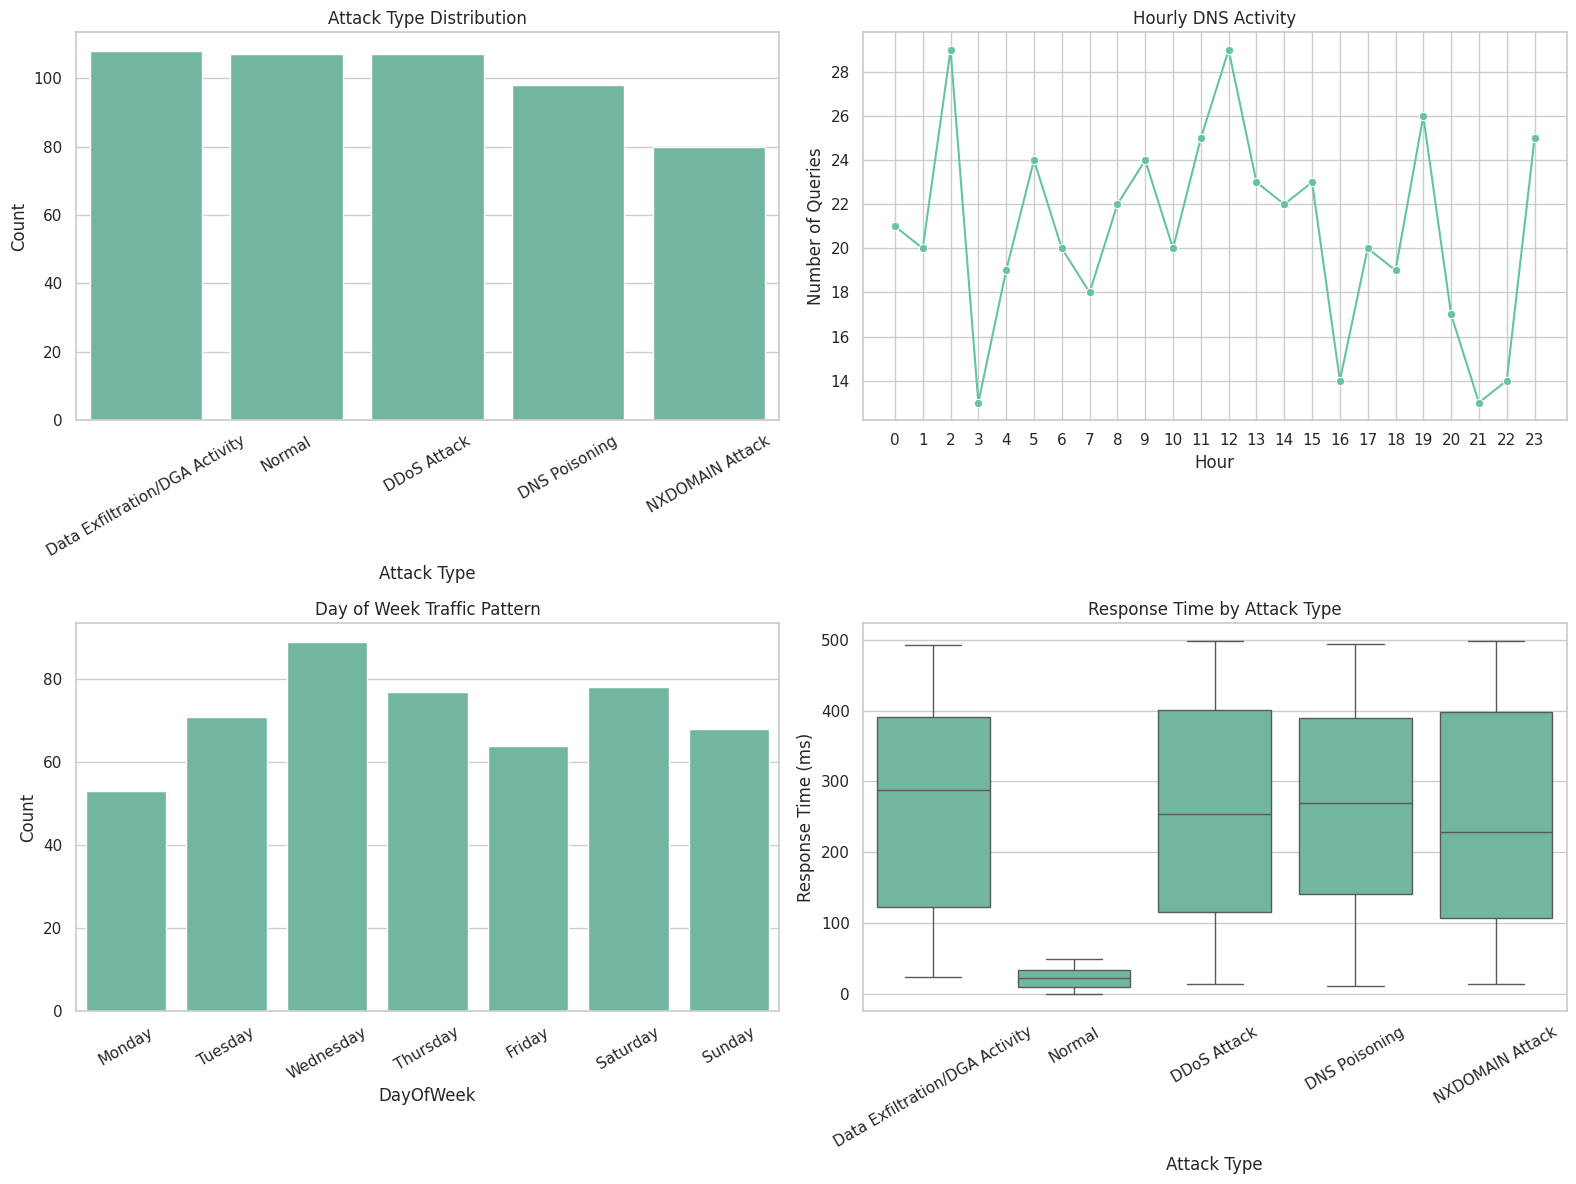

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: map Attack Type numbers to names (if encoded)
attack_mapping = {
    0: "Normal",
    1: "NXDOMAIN Attack",
    2: "DDoS Attack",
    3: "Data Exfiltration/DGA Activity",
    4: "DNS Poisoning"
}
df["Attack Type"] = df["Attack Type"].map(attack_mapping)

# Set Seaborn theme
sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(16, 12))

# 1️⃣ Attack Type Distribution
plt.subplot(2, 2, 1)
sns.countplot(data=df, x="Attack Type", order=df["Attack Type"].value_counts().index)
plt.title("Attack Type Distribution")
plt.xticks(rotation=30)
plt.ylabel("Count")

# 2️⃣ Hourly Activity
plt.subplot(2, 2, 2)
hourly_counts = df.groupby("Hour")["Attack Type"].count().reset_index()
sns.lineplot(data=hourly_counts, x="Hour", y="Attack Type", marker="o")
plt.title("Hourly DNS Activity")
plt.ylabel("Number of Queries")
plt.xticks(range(0, 24))

# 3️⃣ Day of Week Activity
plt.subplot(2, 2, 3)
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(data=df, x="DayOfWeek", order=range(0, 7))
plt.title("Day of Week Traffic Pattern")
plt.xticks(range(0, 7), days, rotation=30)
plt.ylabel("Count")

# 4️⃣ Response Time by Attack Type
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x="Attack Type", y="Response Time (ms)", order=df["Attack Type"].value_counts().index)
plt.title("Response Time by Attack Type")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop Timestamp column if it exists
X_train = X_train.drop(columns=['Timestamp'], errors='ignore')
X_test = X_test.drop(columns=['Timestamp'], errors='ignore')

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42)
}

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"\n{name} Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Random Forest Results
Accuracy: 0.99
                                precision    recall  f1-score   support

                   DDoS Attack       1.00      1.00      1.00        21
                 DNS Poisoning       1.00      0.95      0.97        20
Data Exfiltration/DGA Activity       0.96      1.00      0.98        22
               NXDOMAIN Attack       1.00      1.00      1.00        16
                        Normal       1.00      1.00      1.00        21

                      accuracy                           0.99       100
                     macro avg       0.99      0.99      0.99       100
                  weighted avg       0.99      0.99      0.99       100


Logistic Regression Results
Accuracy: 0.71
                                precision    recall  f1-score   support

                   DDoS Attack       0.76      0.90      0.83        21
                 DNS Poisoning       0.71      0.50      0.59        20
Data Exfiltration/DGA Activity       0.60      0.9

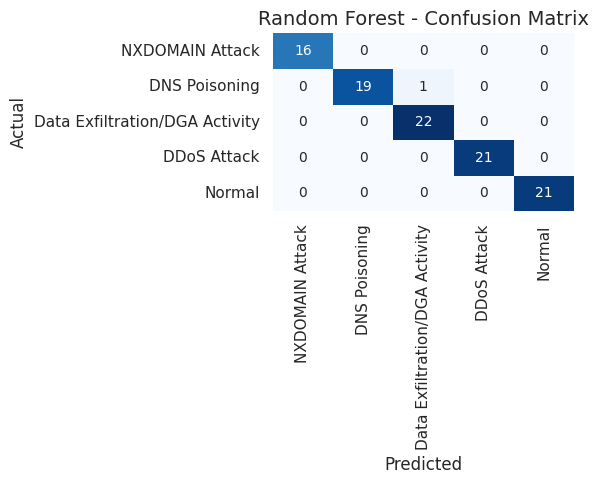

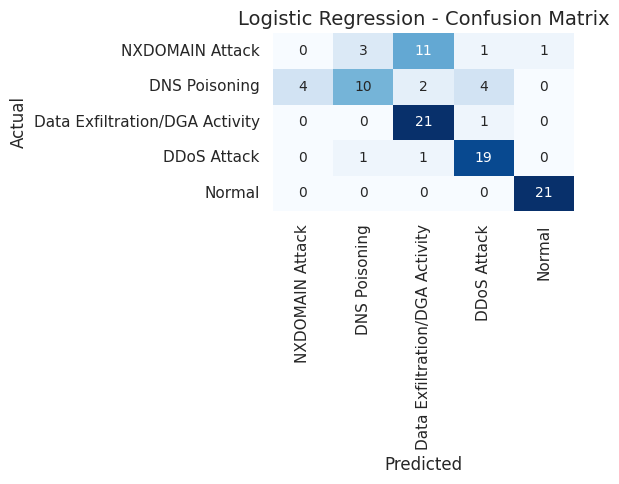

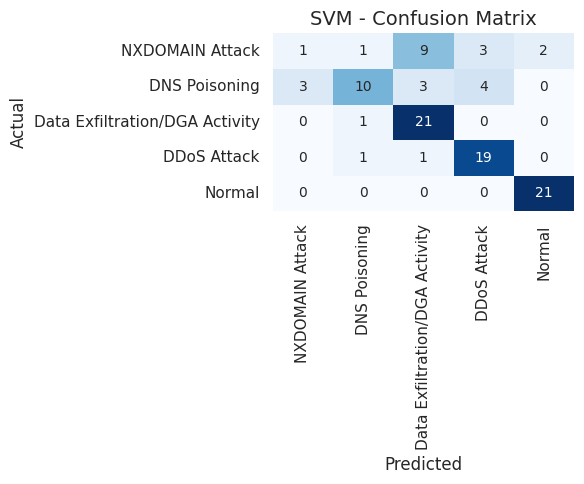

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Class labels (adjust if needed)
labels = y_test.unique()

for name, model in models.items():
    # Train with scaling only for LR and SVM
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Plot cleaner confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar=False, annot_kws={"size": 10})
    plt.title(f"{name} - Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()